### Langchain with Vector Search - Cassandra DB - Datastax

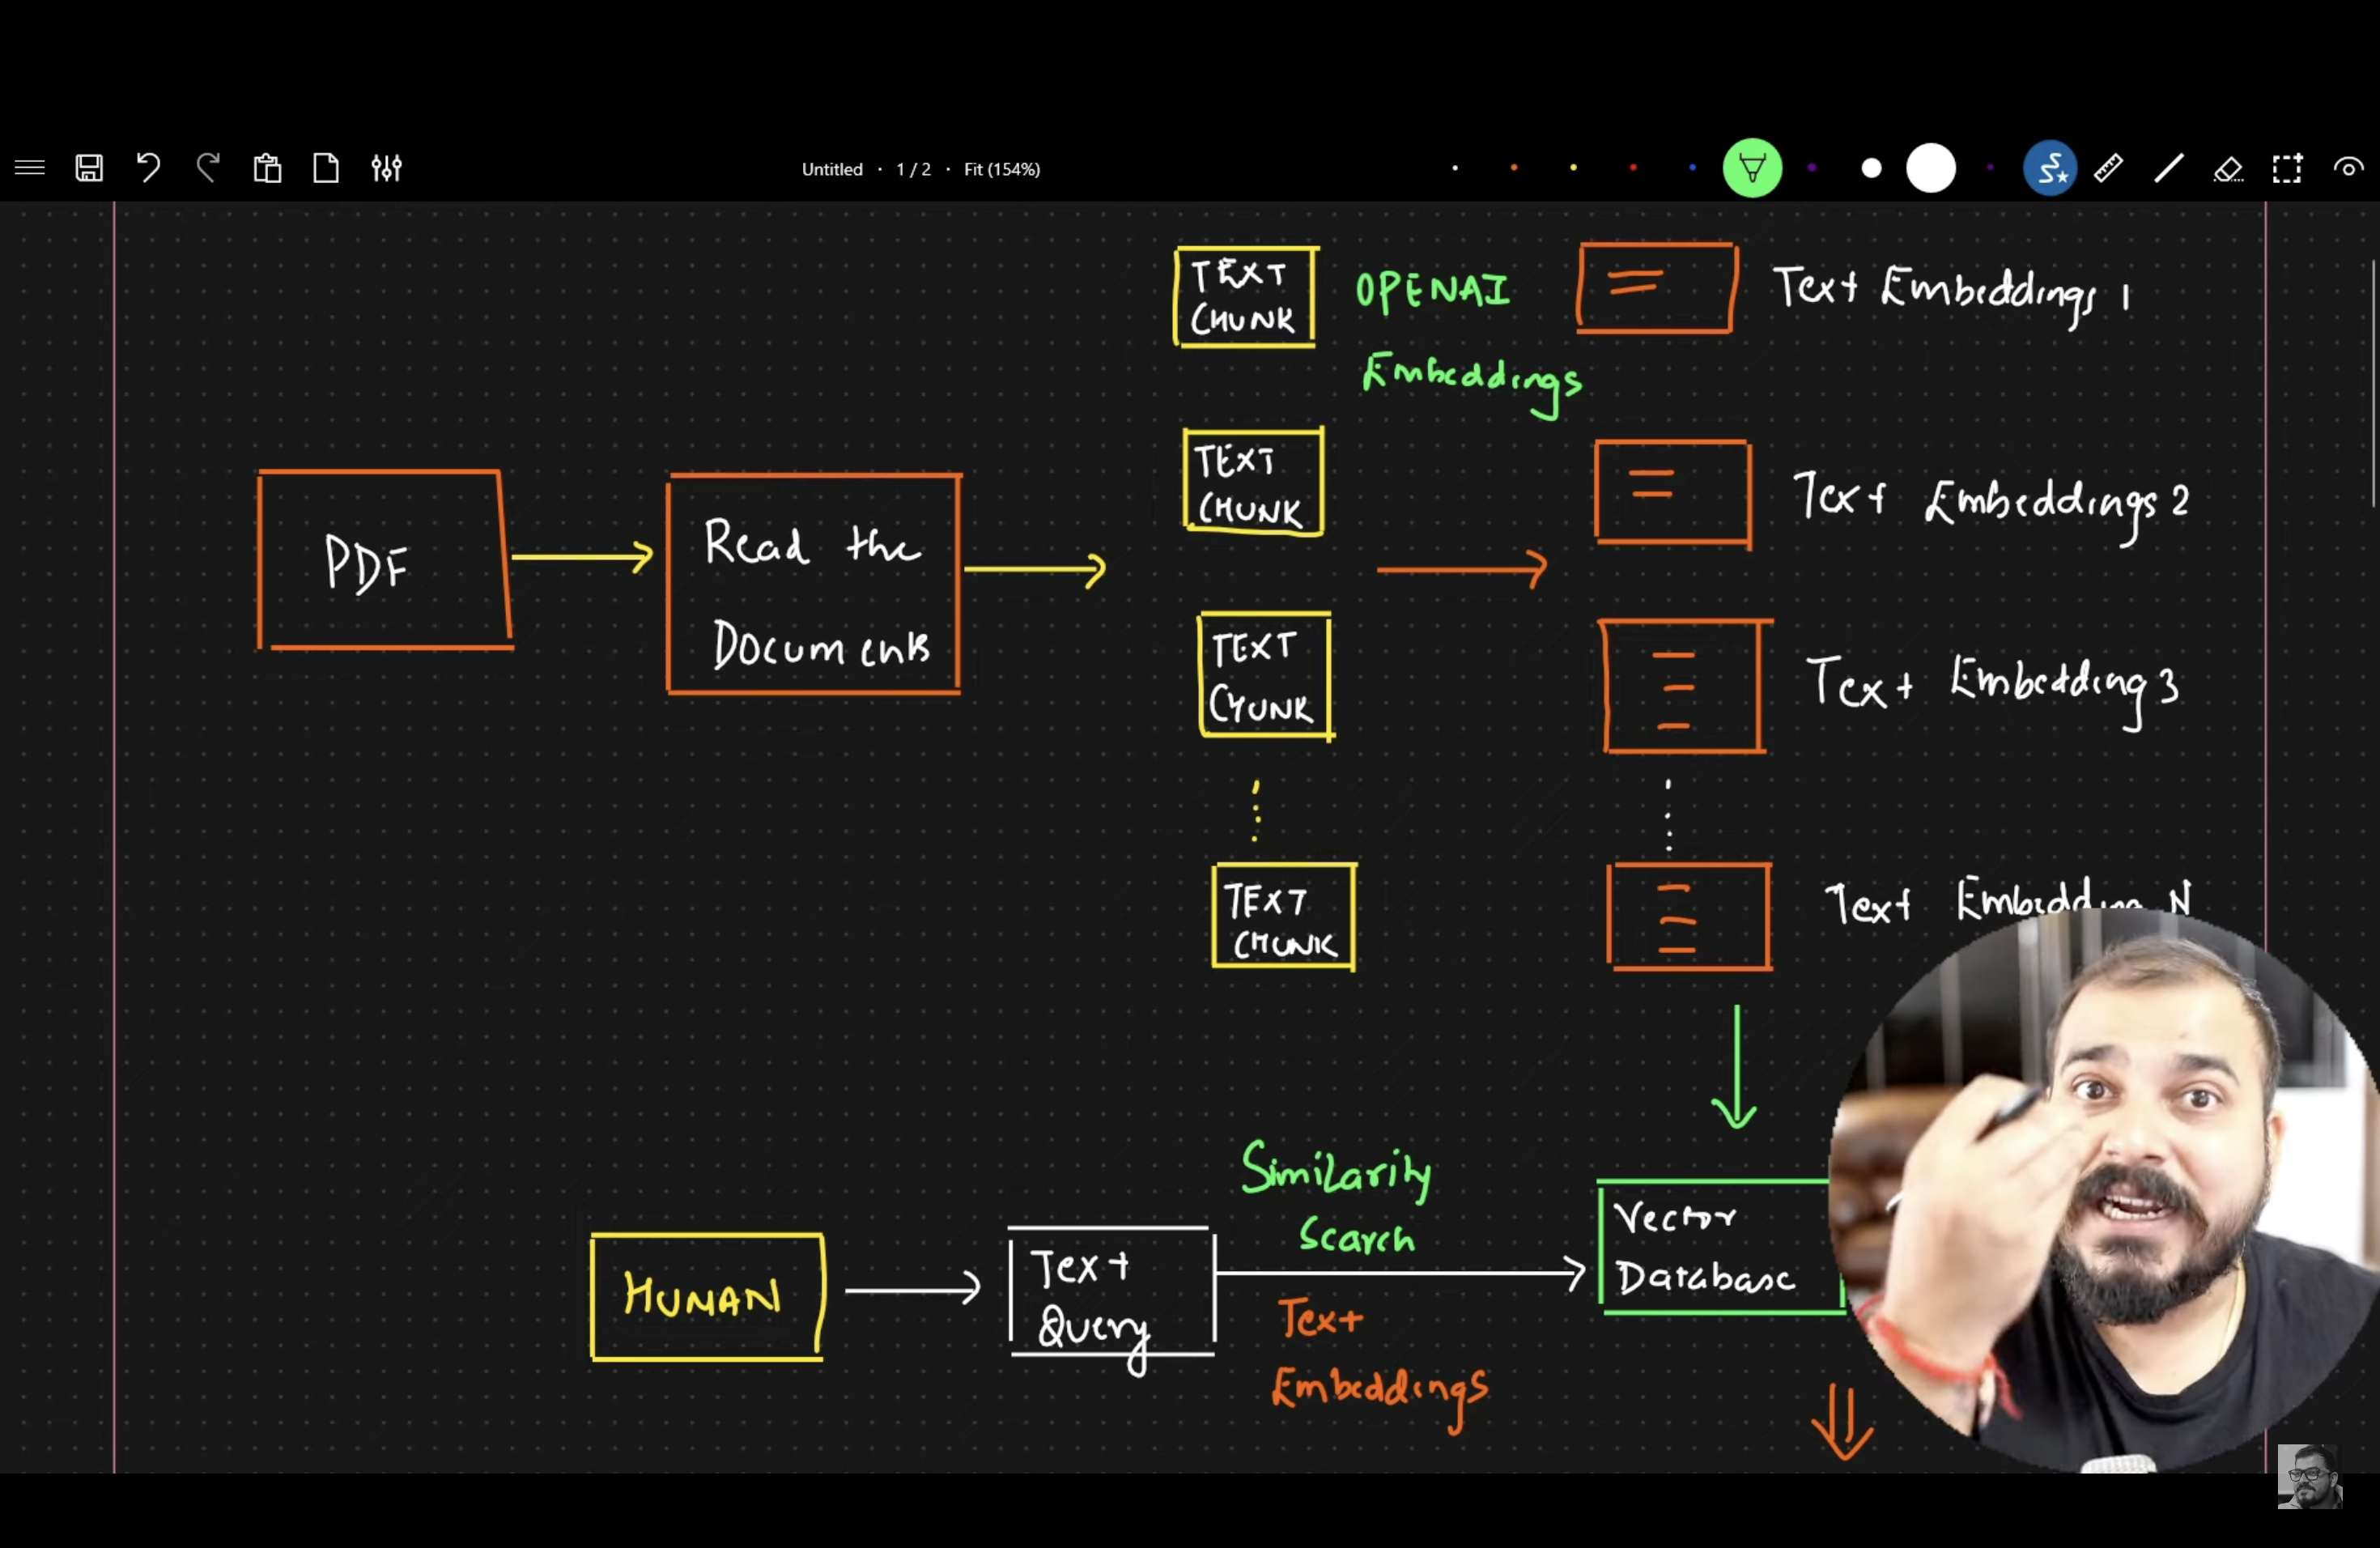

Apache Cassandra : Open source NoSQL Database. We will store all vectors in cassandra DB .We will use Datastax platform to store all vectors .

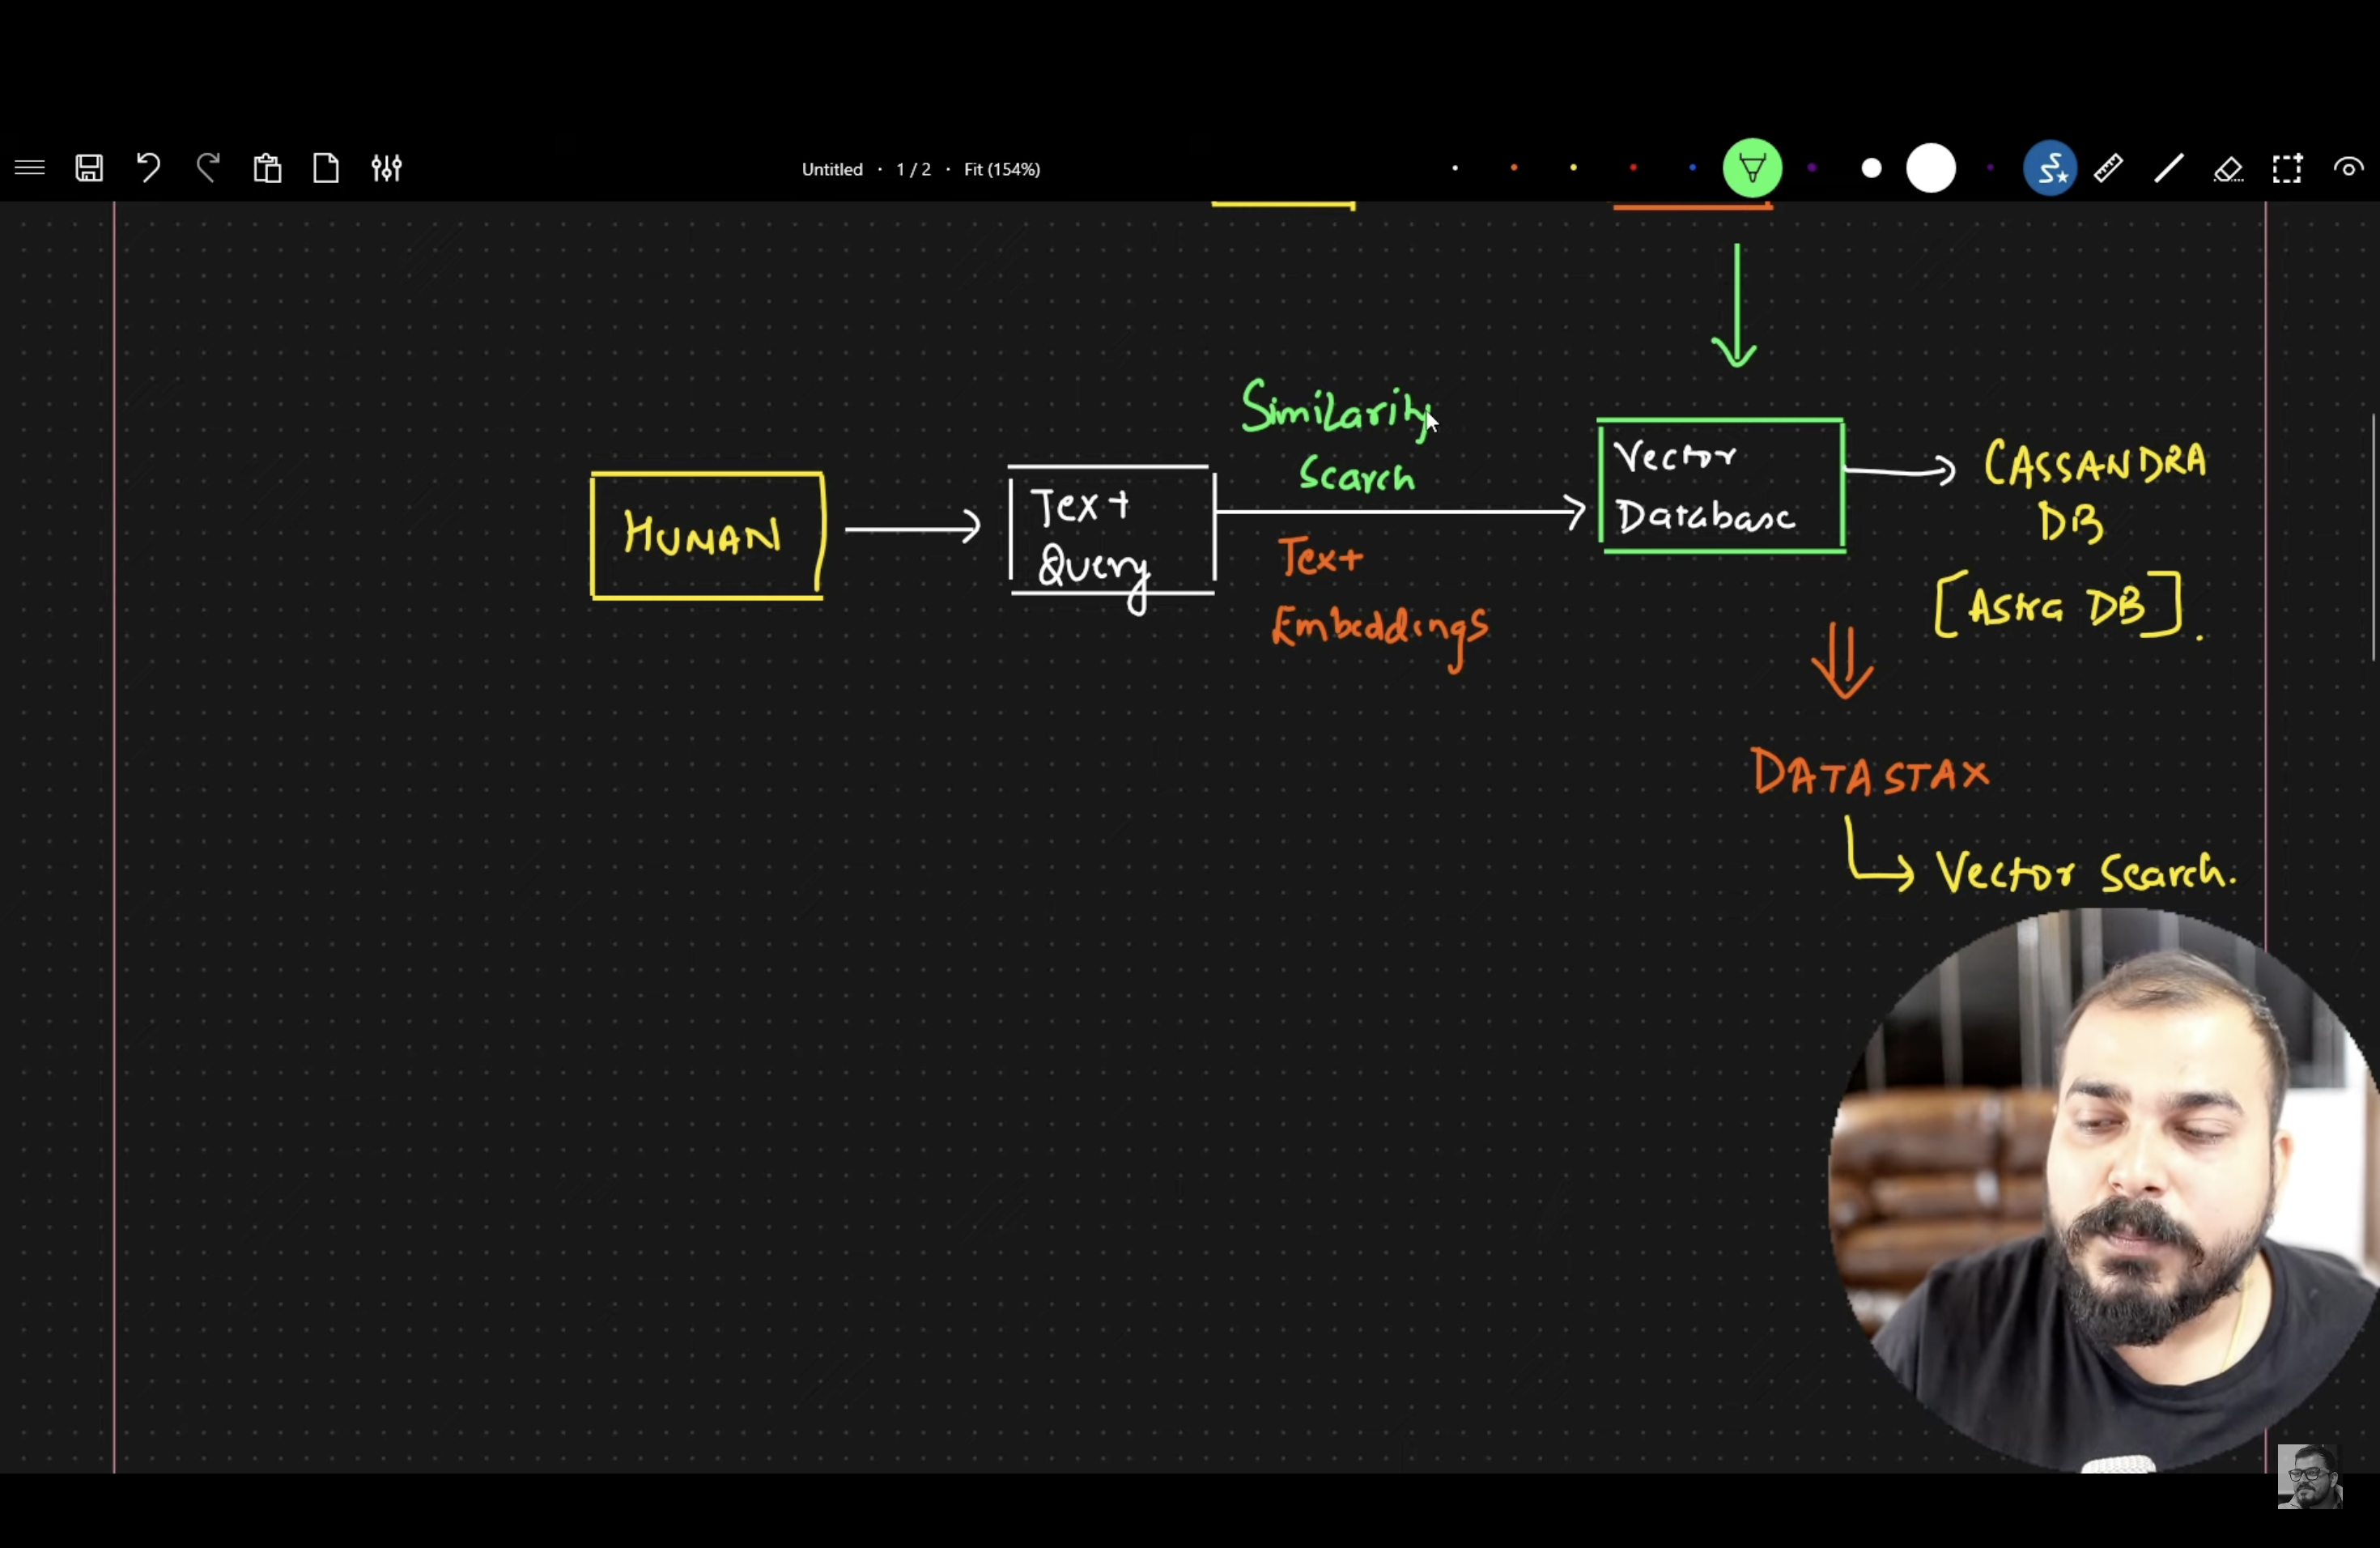


#### Quickstart: Querying PDF With Astra and LangChain

##### A question-answering demo using Astra DB and LangChain, powered by Vector Search

#### Pre-requisites:

You need a **_Serverless Cassandra with Vector Search_** database on [Astra DB](https://astra.datastax.com) to run this demo. As outlined in more detail [here](https://docs.datastax.com/en/astra-serverless/docs/vector-search/quickstart.html#_prepare_for_using_your_vector_database), you should get a DB Token with role _Database Administrator_ and copy your Database ID: these connection parameters are needed momentarily.

You also need an [OpenAI API Key](https://cassio.org/start_here/#llm-access) for this demo to work.

#### What you will do:

- Setup: import dependencies, provide secrets, create the LangChain vector store;
- Run a Question-Answering loop retrieving the relevant headlines and having an LLM construct the answer.

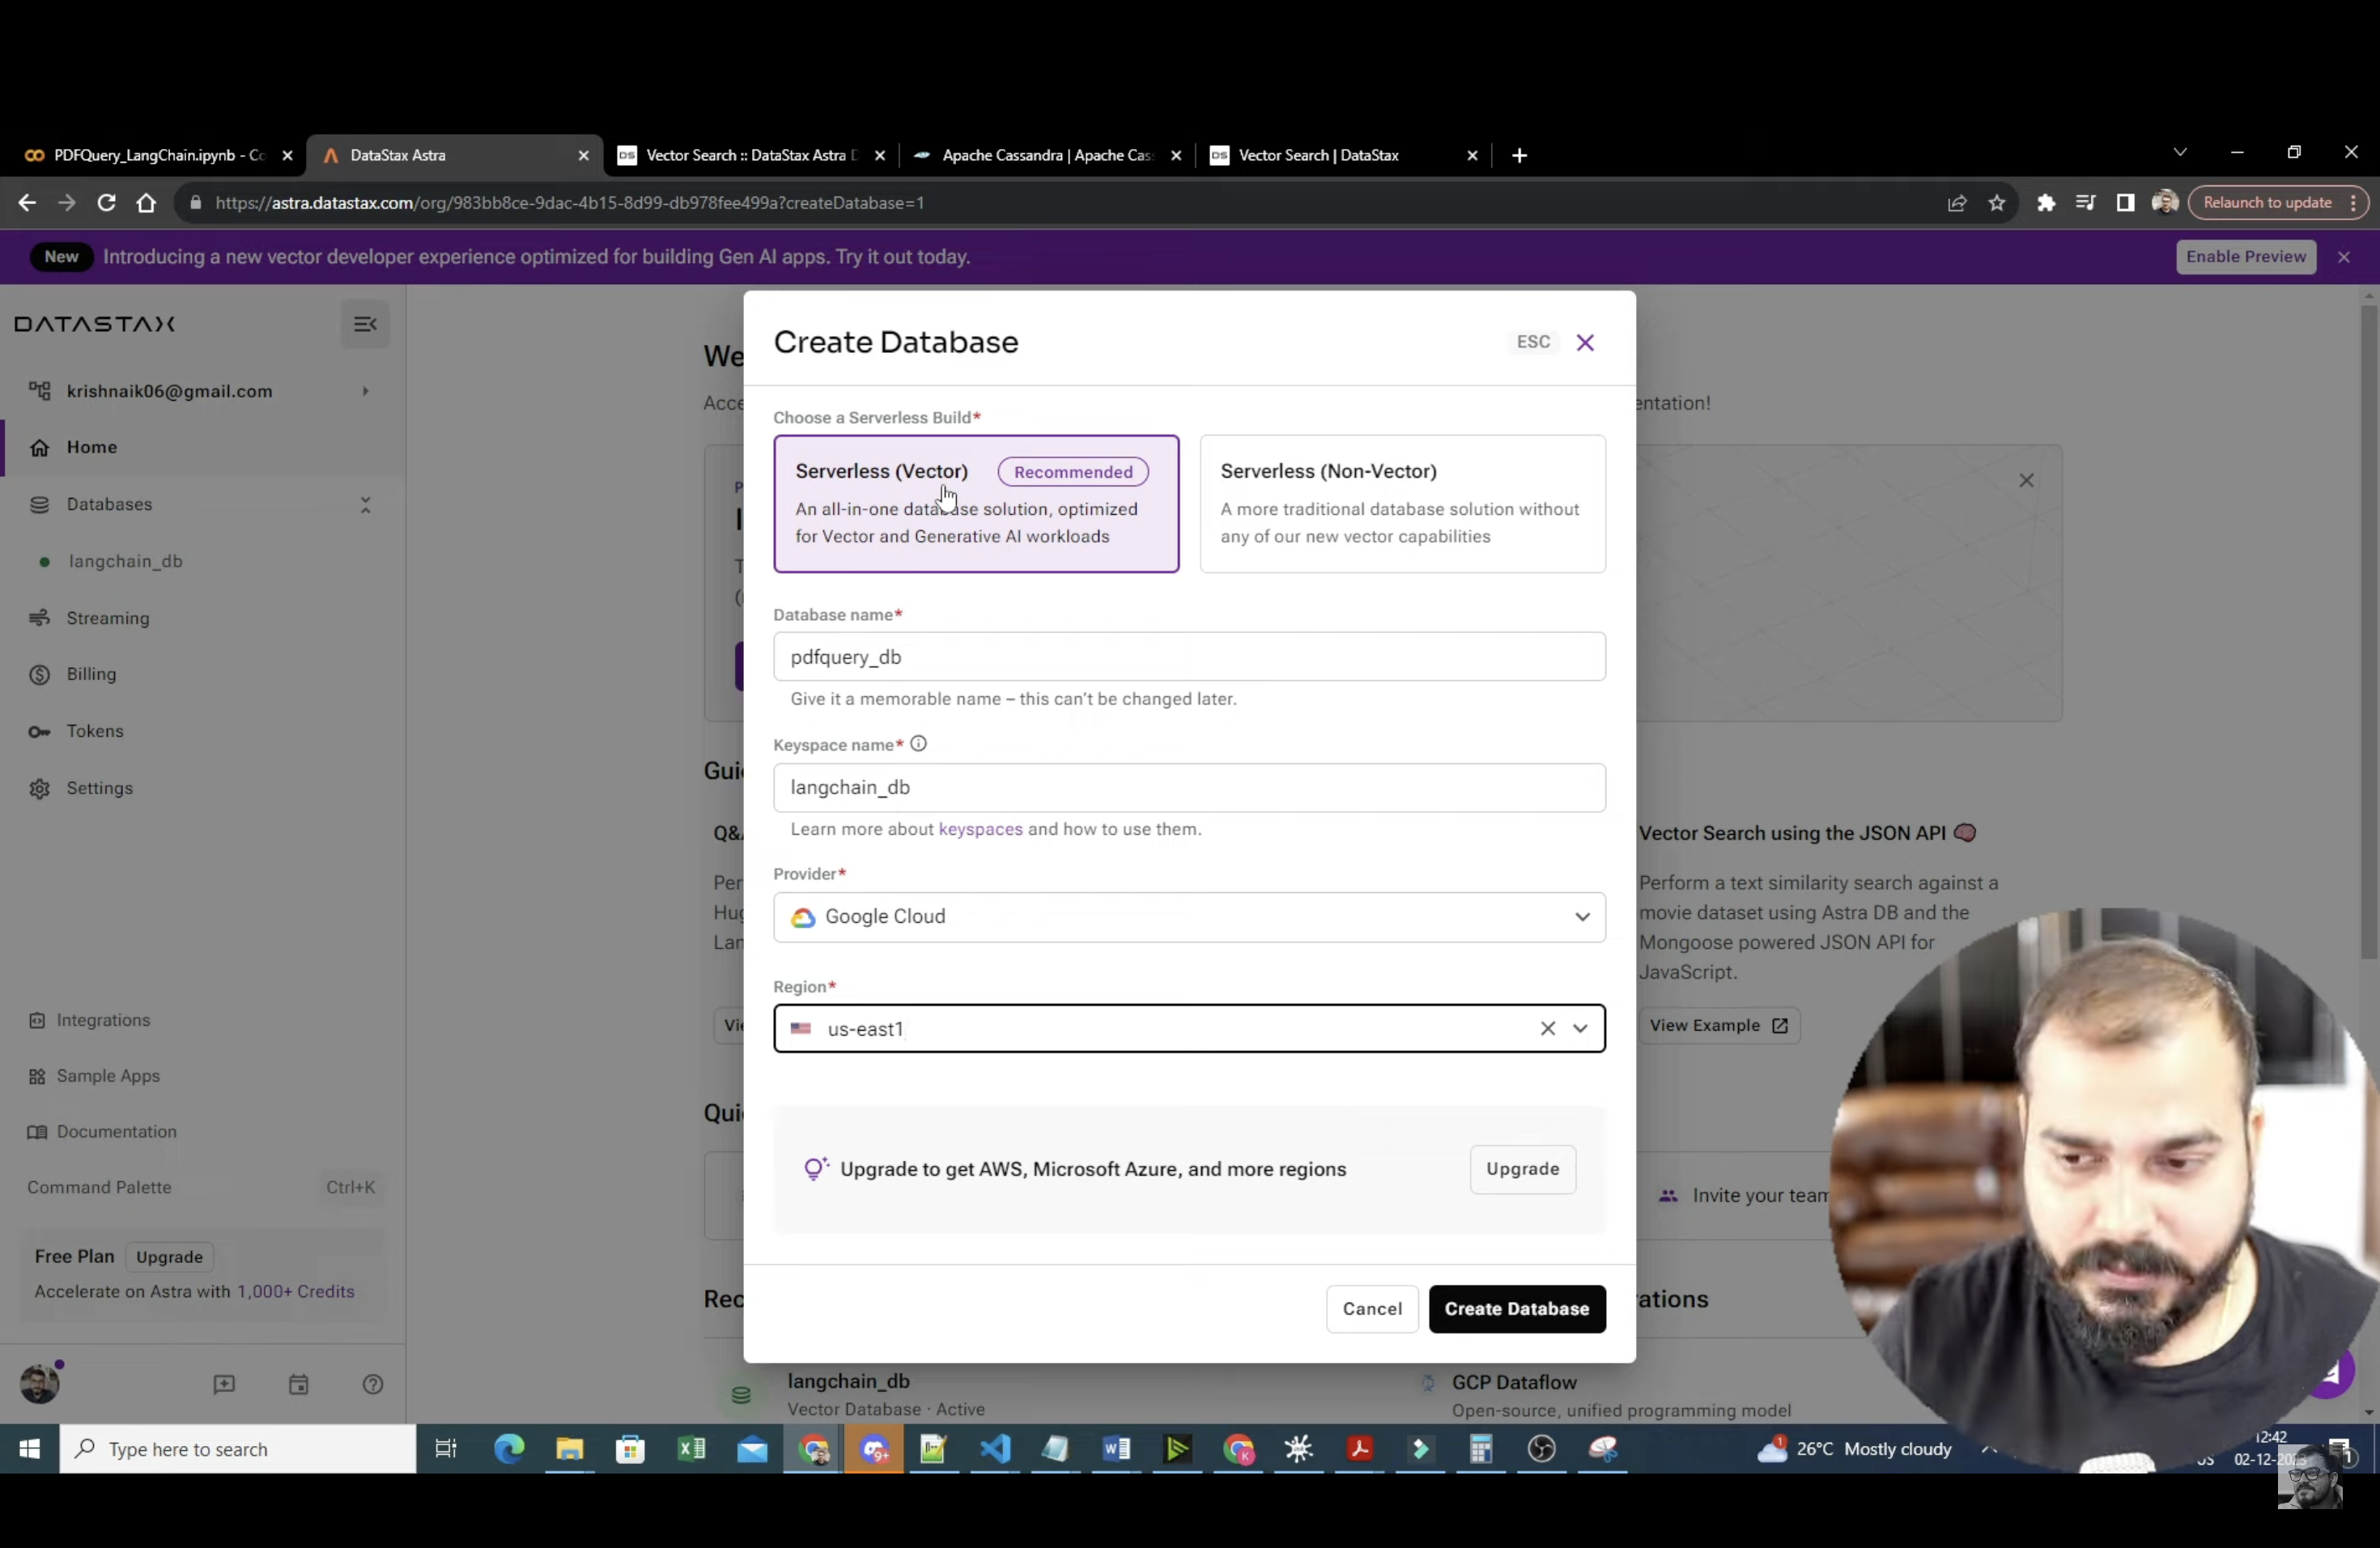

Once database is created. Click on Connect - Generate Token and Use DB ID which is at top

!pip install -q cassio datasets langchain openai tiktoken

In [1]:
# LangChain components to use
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper ## all vectors will be package into one package
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings

# Support for dataset retrieval with Hugging Face
from datasets import load_dataset

# With CassIO, the engine powering the Astra DB integration in LangChain,
# you will also initialize the DB connection:
import cassio

/Users/mfho-27019739/Desktop/AIML/Github/LLM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mfho-27019739/Desktop/AIML/Github/LLM/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


!pip install PyPDF2

In [2]:
from PyPDF2 import PdfReader
from dotenv import load_dotenv
load_dotenv()
import os

ASTRA_DB_APPLICATION_TOKEN = os.environ['ASTRA_DB_APPLICATION_TOKEN']
ASTRA_DB_ID = os.environ['ASTRA_DB_ID']
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

# provide the path of  pdf file/files.
pdfreader = PdfReader('budget_speech.pdf')

from typing_extensions import Concatenate
# read text from pdf
raw_text = ''
for i, page in enumerate(pdfreader.pages):
    content = page.extract_text()
    if content:
        raw_text += content

raw_text

"GOVERNMENT OF INDIA\nBUDGET 2023-2024\nSPEECH\nOF\nNIRMALA SITHARAMAN\nMINISTER OF FINANCE\nFebruary 1,  2023CONTENTS \nPART-A \n Page No.  \n\uf0b7 Introduction 1 \n\uf0b7 Achievements since 2014: Leaving no one behind 2 \n\uf0b7 Vision for Amrit Kaal  – an empowered and inclusive economy 3 \n\uf0b7 Priorities of this Budget 5 \ni. Inclusive Development  \nii. Reaching the Last Mile \niii. Infrastructure and Investment \niv. Unleashing the Potential \nv. Green Growth \nvi. Youth Power  \nvii. Financial Sector  \n \n \n \n \n \n \n \n \n\uf0b7 Fiscal Management 24 \nPART B  \n  \nIndirect Taxes  27 \n\uf0b7 Green Mobility  \n\uf0b7 Electronics   \n\uf0b7 Electrical   \n\uf0b7 Chemicals and Petrochemicals   \n\uf0b7 Marine products  \n\uf0b7 Lab Grown Diamonds  \n\uf0b7 Precious Metals  \n\uf0b7 Metals  \n\uf0b7 Compounded Rubber  \n\uf0b7 Cigarettes  \n  \nDirect Taxes  30 \n\uf0b7 MSMEs and Professionals   \n\uf0b7 Cooperation  \n\uf0b7 Start-Ups  \n\uf0b7 Appeals  \n\uf0b7 Better ta

Initialize the connection to your database:

In [ ]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN, database_id=ASTRA_DB_ID)

Create the LangChain embedding and LLM objects for later usage:

In [9]:
llm = OpenAI(openai_api_key=OPENAI_API_KEY)
embedding = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

Create your LangChain vector store ... backed by Astra DB!

In [ ]:
astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None,
)

from langchain.text_splitter import CharacterTextSplitter
# We need to split the text using Character Text Split such that it sshould not increse token size
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 800,
    chunk_overlap  = 200,
    length_function = len,
)
texts = text_splitter.split_text(raw_text)
texts[:50]

### Load the dataset into the vector store

In [ ]:

astra_vector_store.add_texts(texts[:50]) ## This step also performs embeddings and will also store it in cassandra db

print("Inserted %i headlines." % len(texts[:50]))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store) ## Creating index

### Run the QA cycle

Simply run the cells and ask a question -- or `quit` to stop. (you can also stop execution with the "▪" button on the top toolbar)

Here are some suggested questions:
- _What is the current GDP?_
- _How much the agriculture target will be increased to and what the focus will be_


In [ ]:
first_question = True
while True:
    if first_question:
        query_text = input("\nEnter your question (or type 'quit' to exit): ").strip()
    else:
        query_text = input("\nWhat's your next question (or type 'quit' to exit): ").strip()

    if query_text.lower() == "quit":
        break

    if query_text == "":
        continue

    first_question = False

    print("\nQUESTION: \"%s\"" % query_text)
    answer = astra_vector_index.query(query_text, llm=llm).strip()
    print("ANSWER: \"%s\"\n" % answer)

    print("FIRST DOCUMENTS BY RELEVANCE:")
    for doc, score in astra_vector_store.similarity_search_with_score(query_text, k=4):
        print("    [%0.4f] \"%s ...\"" % (score, doc.page_content[:84]))

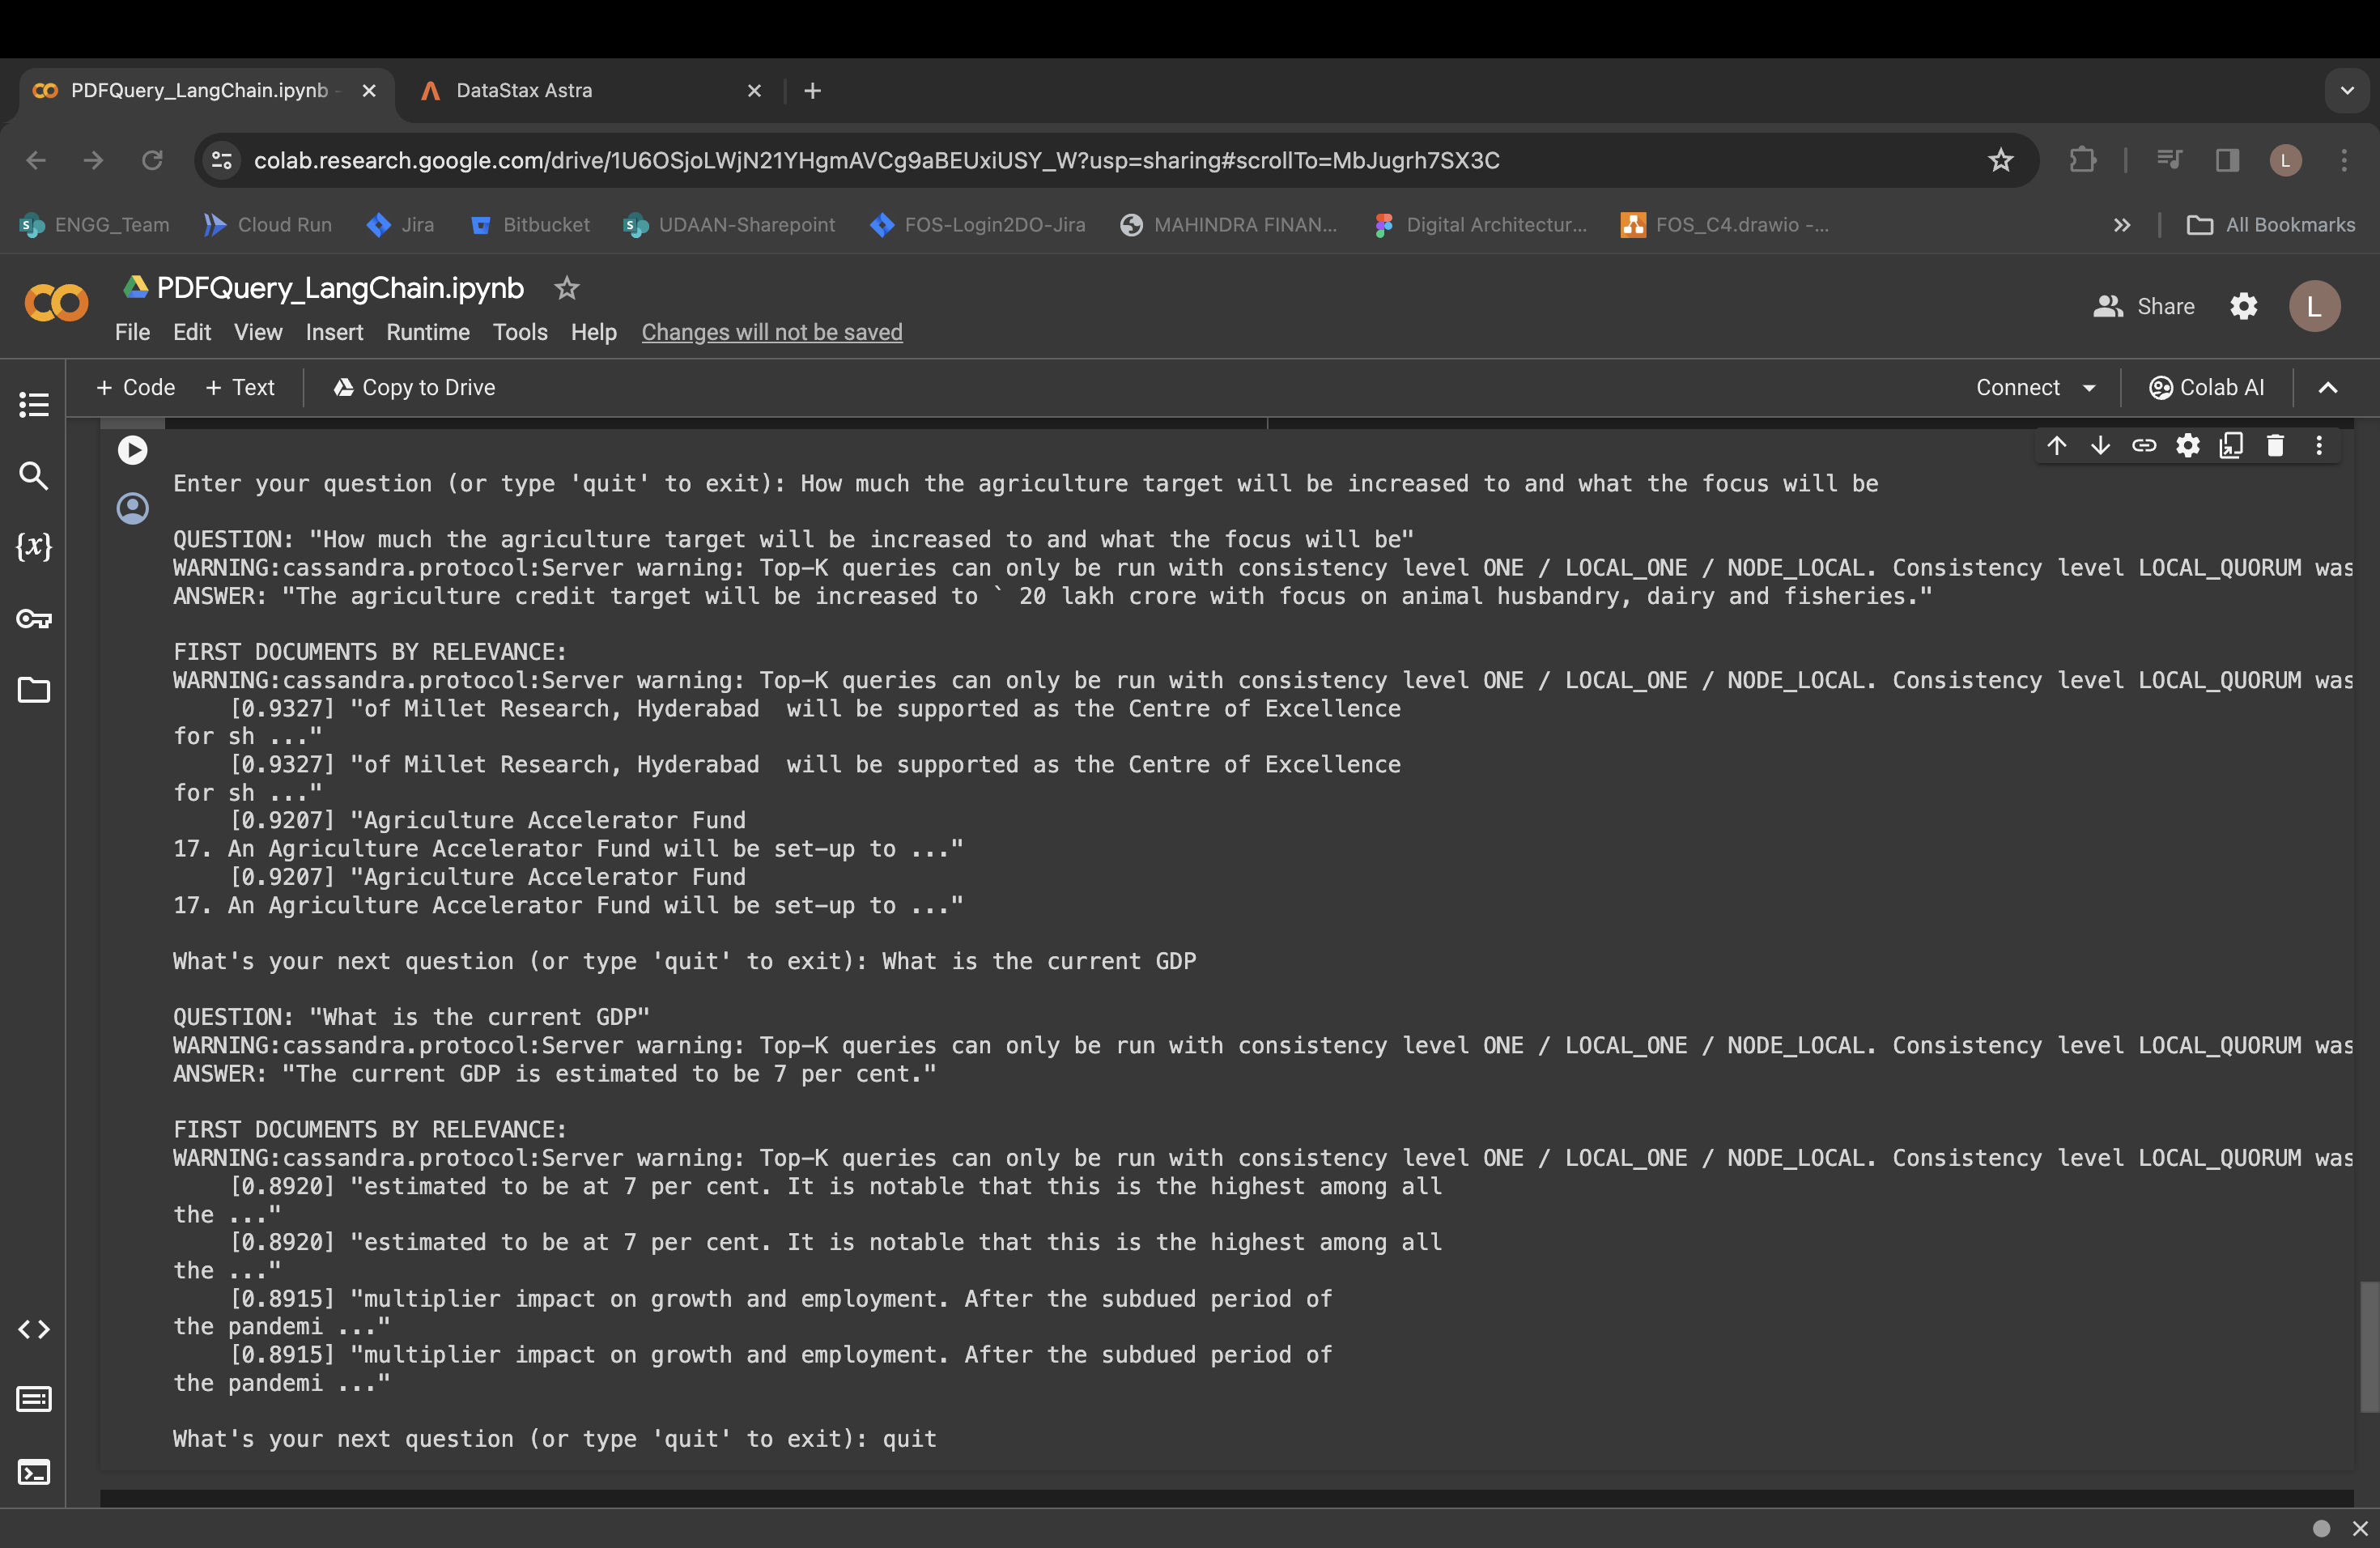